# NN ensemble classifier
Separate signal ($gg\rightarrow hh\rightarrow b\bar{b}\tau\bar{\tau}$) from background ($pp\rightarrow t\bar{t}\rightarrow \ell\bar{\ell}b\bar{b},\ \ell\in\{e,\mu,\tau\}$) using an ensemble of neural networks. Focus is on $\mu\tau_{h}bb$ channel.

## Import

### Import modules

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import pandas
import timeit #more accurate than time

import theano
import tensorflow

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, TensorBoard,ReduceLROnPlateau
from keras.layers import Dense, Activation,Dropout
from keras.models import Sequential, model_from_json, load_model
from keras.constraints import maxnorm
from keras import optimizers
from keras.utils import plot_model
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras.utils.generic_utils import get_custom_objects
from keras.layers.noise import GaussianNoise



import seaborn as sns
sns.set_style("white")
import os
import json

from six.moves import cPickle #Faster than pickle
import sys
sys.path.append('../../modules/')
from MPPlot import *
from Processors import *

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Choose backend

In [2]:
import importlib

def set_keras_backend(backend):
    """
    Changes Keras backend
    
    Parameters
    ----------
    backend : str
              Backend wanted (theano or tensorflow)
              
    Returns
    -------
    """
    
    idm = {"theano": "th", "tensorflow": "tf"}
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
        keras.backend.set_image_dim_ordering(idm[backend])

set_keras_backend("tensorflow")


## Import data
Read ROOT files into Pandas dataframe. Pandas is a very fast and flexibly way of handling data in Python. It stores data in RAM, so doesn't handle large files well...

Data is available in both ROOT and CSV format. Pick which you wish to use.

In [3]:
useROOT = False

In [4]:
loc = "../Data/"
SignalData = []
BackgroundData = []

masses = [260, 270, 280, 300, 320, 400, 500, 550, 600 ,700]
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((masses,backgrounds))

if useROOT: #Load data from ROOT files
    import root_numpy
    signalData = pandas.DataFrame(root_numpy.root2array(loc + "signal.root", treename = 'tree'))
    backgroundData = pandas.DataFrame(root_numpy.root2array(loc + "background.root", treename = 'tree'))

else: #Load data from CSV files
    for mass in masses:
        signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(mass) +"_narrow_13TeV-madgraph.csv")
        signaldata['gen_label'] = str(mass)
        SignalData.append(signaldata)
        
        
    names = { 'TT':loc + "TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv",
              'WJetsToLNu':loc + "WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv"}
    for back in backgrounds:
        backgroundData = pandas.read_csv(names[back])
        backgroundData['gen_label'] = back
        BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)    
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)    
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))
backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))
"""else: #Load data from CSV files
    signalData = pandas.read_csv(loc + "signal.csv")
    backgroundData = pandas.read_csv(loc + "background.csv")
    
    # Drop columns without header
    signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)
    backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)  """

    
    
print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


Samples contains 10417 signal events and 168053 background events
178470 events in total


## Configure data

### Process data and add new features

 - t_0 = $\tau_h$
 - t_1 = $\mu$
 - b_0 & b_1 = selected b-jets ordered by $p_T$
 - mPT = missing transverse-momenta
 - h_tt = vector-sum of t_0, t_1, and mPT ($h\rightarrow\tau\tau$)
 - h_bb = vector-sum of b_0 and b_1 ($h\rightarrow bb$)
 - diH = vector-sum of h_tt and h_bb (di-Higgs vector)

Discrimantion often works better when vectors are in Carteesian coordinates, let's transform our data and add some extra features

In [5]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    addEnergy(data, p) #Calculate energy and absolute momentum

moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu

### Create development and validation samples
Development data is used for training and testing. Validation is used for testing the final classifier. Note that the event selection for signal sometimes selects final-states which don't correspond to the Higgs decay products. gen_mctMatch == 1 indicates that the correct final-sates were chosen. For simplicity we'll just consider these signal events.

This defines lists of indices for signal and background events for the development and validation samples. About 20% of each class is reserved for validation

In [6]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)
bkg_devIndeces, bkg_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 0) & (data.gen_mctMatch == 0)].index.tolist()],
                                 test_size=0.2, random_state=1337)


Here we split the full dataset into the dev and val sets, and define aliases for the cuts necessary to select signal and background events in each.

In [7]:
devData = data.loc[sig_devIndeces].copy()
devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data.loc[bkg_valIndeces].copy(), ignore_index = True)

sigDev = (devData.gen_target == 1) & (devData.gen_mctMatch == 1)
bkgDev = (devData.gen_target == 0)
sigVal = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkgVal = (valData.gen_target == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))
print("Dev: {} of which are signal and {} are background".format(len(devData[sigDev]), len(devData[bkgDev])))
print("Val: {} of which are signal and {} are background".format(len(valData[sigVal]), len(valData[bkgVal])))


138371 events for training, 34594 events for validation
Dev: 3929 of which are signal and 134442 are background
Val: 983 of which are signal and 33611 are background


Since there are more background events, let's define weights to help balance out the classes.

In [8]:
classWeights = {0.0 : 1.0,
                1.0 : len(devData[bkgDev])/len(devData[sigDev])}

print("Dev Weights are: ", classWeights)

Dev Weights are:  {0.0: 1.0, 1.0: 34.217867141766355}


## Options
Define the features used for discrimination and training options

### Feature sets

In [9]:
genFeatures = [var for var in data.columns if str.startswith(var, "gen")] #Generator features; not for training
trainFeatures = [var for var in data.columns if var not in genFeatures] #Reconstructed features; ok for training


We no longer need the old $p_T$, $\eta$, and $\phi$ coordinates so remove them from the training features. 't_1_mass' is also constant ($m_{\mu}$) so let's remove that too.

In [10]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi', 't_1_mass', 'h_tt_svFit_mass', 'diH_kinFit_mass' ,'diH_kinFit_prob' , 'b_0_csv' ,'b_1_csv','diH_mass'] if x in var]
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi]
print(trainFeatures)

['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT']


Let's divide up the available features into sets

In [11]:
fsFeatures = [var for var in trainFeatures for p in particles + ['mPT'] if p in var]
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']


### Training options
Here we define the way we'll train the classifier. For simplicity we'll just use the low-level final-state features. We can also choose what pre-processing step to apply to the data.

In [12]:
classTrainFeatures = fsFeatures #The features used
classModel = "model0" #Will define the layout of the network
varSet = "fsFeatures" #Name of the feature set used, mainly for saving results
normIn = True #Whether we want to normalise and standardise the inputs
pca = True #Whether we want to use principal-component analysis to decorrelate inputs
whiten = False #Whether we want to whiten input data
nSplits = 10 #Number of train/test splits to make during cross-validation
ensembleSize = 5 #Number of classifiers  to include in ensemble = min(nSplits, ensembleSize)
ensembleMode = 'loss' #Metric used to weight classifiers in ensemble, I've found loss to quite relaible


compileArgs = {'loss':'binary_crossentropy', 
               'optimizer':'adam'} #Loss function and optimiser for NN
trainParams = {'epochs' : 10000, 
               'batch_size' : 64, 
               'verbose' : 1} #Maximum epochs for training and size of mini-batch
print("Training on {} features {}". format(len(classTrainFeatures),[var for var in classTrainFeatures]))



Training on 44 features ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT']


## Pre-process data

Here we define a SK-Learn pipeline which will contain transformation steps for any data fed in. Pipelines are a nice, compact way of handing data transformations.

In [13]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []

Next we fit the pipeline to the **development** data inputs. For compactness we also transform the development data and create Numpy arrays of the inputs and targets. **N.B.** The type of the inputs will normally be either float32 or float64. float32 is preferred, since speed and memory outweighs precision. Sometimes if the data is naturally in float64, the conversion to float32 can can result in NaNs or infs, so watch out.

In [14]:

X_class = inputPipe.fit_transform(devData[classTrainFeatures].values.astype('float32')) #Inputs
y_class = devData['gen_target'].values.astype('int') #Outputs

print(data.columns)

Index(['t_0_pT', 't_0_eta', 't_0_phi', 't_0_mass', 't_1_pT', 't_1_eta',
       't_1_phi', 't_1_mass', 'b_0_pT', 'b_0_eta',
       ...
       'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px',
       'mPT_py', 'mPT_|p|', 't_1_mT'],
      dtype='object', length=124)


## Define classifier
Here we define the layout of the neural network. The basic class is sequential. The network is them defined by adding dense layers (which contain the neurons and weights) and then the activation function. The activation function can be defined directly in the dense constructor, however adding separately gives a clearer picture of the network, and allows it to be easily replaced with an advanced activation-function.

For contempory ML, the rectified linear unit is generally the default activation function. Since we want the outputs to be between 0 (background) and 1 (signal) we'll use the sigmoid function as the final activation function, since it saturates at these values and is symmetric between them.

The compile step combines the choice of loss function and optimiser into the model.

In [15]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale*K.elu(x, alpha)



def getClassifier(model, nIn, compileArgs):
    classModel = Sequential()
    depth = None
    width = None
    if model == "model0":
        depth = 3
        width = 100
    classModel.add(Dense(width, input_dim=nIn)) #First layer requires number of inputs
    #classModel.add(GaussianNoise(0.01))
    classModel.add(Activation('selu'))
    
    
   
    for i in range(depth): #Continue to add hidden layers
        classModel.add(Dense(width)) #Subsequent layers inherit input_dim from previous layer
     
        classModel.add(Activation('selu'))
       
        
    classModel.add(Dense(1, activation='sigmoid')) #Final layer requires one output
    classModel.compile(**compileArgs) #Compile the network graph to prepare it for use
    return classModel

### Callbacks

Callbacks are methods that can be called during training. They have a variety of uses such as monitoring training, stopping training early, and saving different versions of the model. Here we define our own callback,  which saves the history of the training.

We want to view the history of the model's performance on the training and testing data during data, however by default the training loss is averaged over the epoch, and the test loss is evaluated at the end of the epoch, so is not comparable. This modified version evaluates the performance on the training data at the end of each epoch.

Later well also use some other callbacks:

EarlyStopping monitors a specified metric and stops the training if the performance fails to improve for a specified number of epochs in a row. Here we use it to monitor the loss on the test data and stop when it doesn't improve after 10 epochs.

ModelCheckpoint is used to save the weights of the network during training. It's quite flexible, but here we use it save the model which performs best according to the loss in test data.

Normally during training, the test loss will reach a minimum and either saturate or start to increase (overtraining). The training loss will normally either saturate or continue to decrease. The optimum point is when the test-loss first reaches its minimum point. The combination of EarlyStopping and ModelCheckpoint acts to save the model at this point and allow some leeway in case it starts to decrease again.

In [16]:
class LossHistory(Callback):
    def __init__(self, trData):
        self.trainingData = trData
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []
        self.losses['val_acc'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingData[0], self.trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))
        self.losses['val_acc'].append(logs.get('val_acc'))
        


## Train classifier

Now we're ready to train the classifier.

We use stratified k-fold cross-validation for training. This splits the full development data into *k* sets, trains the model on $k-1$ sets and tests its performance on the remainings set. This then continues *k* times with a different set being used for testing each time. The *stratified* part means that each set will contain the same fraction of event classes as the full dataset, which helps ensure unbiased training and means that our class weights will be valid.

During training we save each trained model, as well as its performance on the test set.

**N.B.** The model can either be saved directly, or by saving the weights and layout separately. The former is more compact, but doesn't handle custom objects well. If you've used a custom loss or activation function, the the second method is more flexible. It also seems to be quicker, but I've not done concrete tests...

Running fold 10 / 10
Train on 124535 samples, validate on 13836 samples
Epoch 1/10000
124535/124535 [==============================] - 13s - loss: 0.6378 - val_loss: 0.2676
Epoch 2/10000
124535/124535 [==============================] - 13s - loss: 0.5005 - val_loss: 0.2403
Epoch 3/10000
124535/124535 [==============================] - 16s - loss: 0.4618 - val_loss: 0.2360
Epoch 4/10000
124535/124535 [==============================] - 14s - loss: 0.4349 - val_loss: 0.2353
Epoch 5/10000
124535/124535 [==============================] - 18s - loss: 0.4104 - val_loss: 0.2654
Epoch 6/10000
124535/124535 [==============================] - 12s - loss: 0.3958 - val_loss: 0.1767
Epoch 7/10000
124535/124535 [==============================] - 16s - loss: 0.3787 - val_loss: 0.1950
Epoch 8/10000
124535/124535 [==============================] - 12s - loss: 0.3676 - val_loss: 0.1928
Epoch 9/10000
124535/124535 [==============================] - 12s - loss: 0.3577 - val_loss: 0.2000
Epoch 10/10000
1245

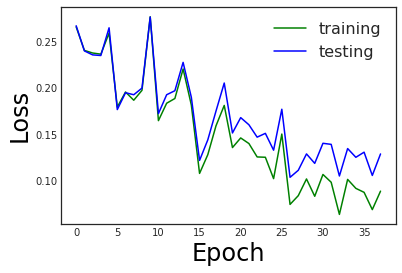


Cross-validation took 5567.537s 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 100)               4500      
_________________________________________________________________
activation_37 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_38 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_39 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)  

In [17]:
from IPython import display

start = timeit.default_timer()

results = []
histories = []

os.system("mkdir train_weights")
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")

skf = StratifiedKFold(n_splits=nSplits, shuffle=True)
plt.figure(figsize=(16,8))

i = 0

  
for train, test in skf.split(X_class, y_class): #test and train are sets of indices for the current CV fold
    i += 1
    display.clear_output(wait=True)
    print("Running fold", i, "/", nSplits)
    
    model = None # Clearing the NN
    model = getClassifier(classModel, len(classTrainFeatures), compileArgs)
    model.reset_states #Just checking
    
    lossHistory = LossHistory((X_class[train], y_class[train]))
    earlyStop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, verbose=0, mode='auto')
    saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, 
                              save_best_only=True, save_weights_only=True, mode='auto', period=1)
    #tensorboard=TensorBoard(log_dir="./logs", histogram_freq=1, batch_size=128,write_grads=True,embeddings_freq=1)
       #Begin training the model
    
    model.fit(X_class[train], y_class[train], validation_data = (X_class[test], y_class[test]),
              class_weight = classWeights, callbacks = [earlyStop, saveBest, lossHistory], **trainParams)
    
    histories.append(lossHistory.losses) #Saves the loss history from callback  
    model.load_weights("train_weights/best.h5") #Loads the best model saved by ModelCheckpoint
    plt.plot(histories[i-1]['loss'], color='g',label = 'training')
    plt.plot(histories[i-1]['val_loss'], color='b', label = 'testing')
    
    results.append({})
    results[-1]['loss'] = model.evaluate(X_class[test], y_class[test], verbose=1) #Gets loss on test data
    results[-1]['AUC'] = 1-roc_auc_score(y_class[test], model.predict(X_class[test], verbose=1)) #Gets ROC AUC for test data
    print("Score is:", results[-1])
    
    model.save('train_weights/train_' + str(i-1)  + '.h5') #Save the model
    plt.legend(fontsize=16)
    plt.xlabel("Epoch", fontsize=24, color='black')
    plt.ylabel("Loss", fontsize=24, color='black')
    plt.show()
    print("\nCross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    
with open('train_weights/resultsFile.pkl', 'wb') as fout: #Save results
    cPickle.dump(results, fout)



X_class = None
y_class = None
train = None
test = None
model.summary() #Prints a summary of the model layout
model = None

### Plot histories
Now let's plot the history of the training.

We can see that the test loss starts to decrease, reaches a minimum point, then begins to increase. The training loss continues to decrease. The early stopping detects the lack of imporvement in test loss and stops the training. The checkpoint allows us to use the state of the model at the minimum point of training loss.

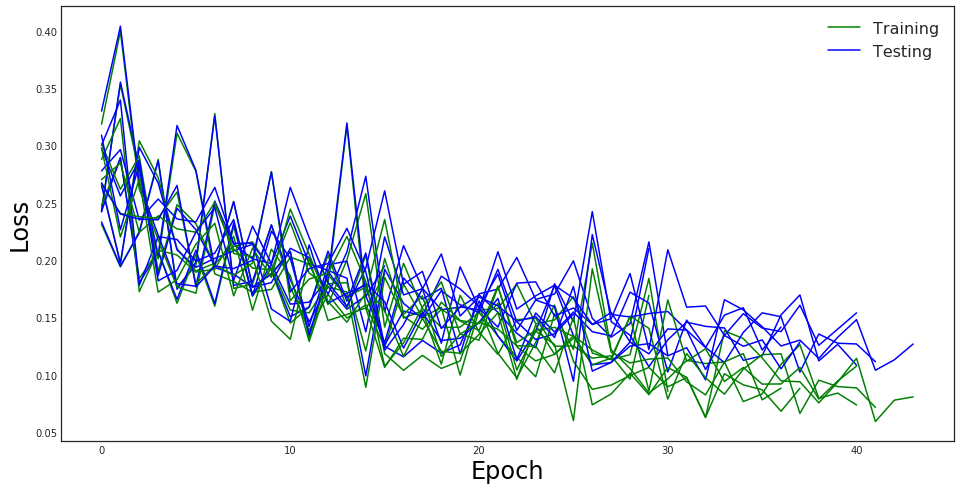

In [18]:
plt.figure(figsize=(16,8))

for i, history in enumerate(histories):
    if i == 0:
        plt.plot(history['loss'], color='g', label='Training')
        plt.plot(history['val_loss'], color='b', label='Testing')
    else:
        plt.plot(history['loss'], color='g')
        plt.plot(history['val_loss'], color='b')
        
plt.legend(fontsize=16)
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("Loss", fontsize=24, color='black')
plt.show()

## Construct ensemble
During the *k*-fold CV we trained *k* models. We could just use the best one, however it is unlikely to optimimum for all input possibilities. Ensembling is a method of using multiple classifiers together to achieve a better result than a single one on its own.

The method I use here is to weight the contributions of each classifier according to how well it performed on its test set during CV.

In [19]:
results = None
with open('train_weights/resultsFile.pkl', 'rb') as fin: #Reload results in case notebook was closed
    results = cPickle.load(fin)

In [20]:
def loadModel(cycle, location='train_weights/train_'): #Function to load a specified classifier
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [21]:
def getWeights(value, met): #How the weight is calculated. Metrics configured such that lower values are better.
    return 1/value #Reciprocal of metric is a simple way of assigning larger weight s to better metrics

Now we order the classifiers by performance, load the required number, and weight them

In [22]:
ensemble = []
weights = []

print("Choosing ensemble by", ensembleMode)
dtype = [('cycle', int), ('result', float)]
values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], 
                          dtype=dtype), order=['result'])

for i in range(min([ensembleSize, len(results)])):
    ensemble.append(loadModel(values[i]['cycle']))
    weights.append(getWeights(values[i]['result'], ensembleMode))
    print("Model {} is {} with {} = {}". format(i, values[i]['cycle'], ensembleMode, values[i]['result']))
    
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 7 with loss = 0.0943481205717804
Model 1 is 2 with loss = 0.09563471557777567
Model 2 is 4 with loss = 0.09907862403523399
Model 3 is 6 with loss = 0.10236946506118702
Model 4 is 9 with loss = 0.10320861423999313


## Response on dev data

Now let's apply the ensemble to the whole of the development data

### Pre-process data

In [23]:
X_dev = inputPipe.transform(devData[classTrainFeatures].values.astype('float32'))

### Get response

In [24]:
def predict(inData, ensemble, weights, n=-1): #Loop though each classifier and predict data class
    pred = np.zeros((len(inData), 1))
    if n == -1:
        n = len(ensemble)+1
    ensemble = ensemble[0:n] #Use only specified number of classifiers
    weights = weights[0:n]
    weights = weights/weights.sum() #Renormalise weights
    
    for i, model in enumerate(ensemble):
        pred += weights[i] * model.predict(inData, verbose=0)
        
    return pred

In [25]:
pred = predict(X_dev, ensemble, weights)
devData['pred_class'] = pandas.Series(pred[:,0], index=devData.index) #Add predicted class to data

In [26]:
devAUC = roc_auc_score(devData["gen_target"].values.astype('int'), devData['pred_class'])
print('Area under ROC curve for development data is {:.5f}'.format(devAUC))

Area under ROC curve for development data is 0.99700


### Ensemble testing
What benefit does ensembling bring? Let's take a look!

In [27]:
for i in range(ensembleSize):
    auc = roc_auc_score(devData["gen_target"].values.astype('int'),
                        predict(X_dev, ensemble, weights, i+1))
    if not i:
        print("AUC using best classifier:\t{:.5f}".format(auc))
    else:
        print("AUC using {} classifiers:\t{:.5f}".format(i+1, auc))

AUC using best classifier:	0.99257
AUC using 2 classifiers:	0.99619
AUC using 3 classifiers:	0.99589
AUC using 4 classifiers:	0.99685
AUC using 5 classifiers:	0.99700


Definite improvements seen, but the improvements will eventually saturate. The number to use and the ways the weights are calculated are hyperparameters of the MVA. We could have set aside some of the development data for tuning this, but for now we'll just stick with what we have.

## Response on val data
Having done all the development of the classifier, we're now ready to do final testing on the withheld validation data.

### Pre-process data

In [28]:
X_val = inputPipe.transform(valData[classTrainFeatures].values.astype('float32'))

### Get response

In [29]:
pred = predict(X_val, ensemble, weights)
valData['pred_class'] = pandas.Series(pred[:,0], index=valData.index) #Add predicted class to data

In [30]:
valAUC = roc_auc_score(valData["gen_target"].values.astype('int'), valData['pred_class'])
print('Area under ROC curve for validation data is {:.5f}'.format(valAUC))

Area under ROC curve for validation data is 0.98039


### Ensemble testing
Again we can confirm that ensembling helps. **N.B.** Do not use the validation data for any tuning!

In [31]:
for i in range(ensembleSize):
    auc = roc_auc_score(valData["gen_target"].values.astype('int'),
                              predict(X_val, ensemble, weights, i+1))
    if not i:
        print("AUC using best classifier:\t{:.5f}".format(auc))
    else:
        print("AUC using {} classifiers:\t{:.5f}".format(i+1, auc))

AUC using best classifier:	0.97556
AUC using 2 classifiers:	0.97776
AUC using 3 classifiers:	0.98000
AUC using 4 classifiers:	0.98007
AUC using 5 classifiers:	0.98039


## Evaluation

### ROC curve
In the earlier evaluations of the ROC AUC we took the data altogether giving one evaluation of the ROC and no uncertainty. Instead we can sample the predictions with replacement and evaluate the ROC on the bootstrap samples. By doing this many times we can converge to a better estimation of true ROC AUC, and get an uncertainty.

This takes a while so we'll use multithreading to evaluate both development and validation performance at once.

In [32]:
aucArgs = [{'labels':valData['gen_target'], 'preds':valData['pred_class'], 
            'name':'Val', 'indeces':valData.index.tolist()},
           {'labels':devData['gen_target'], 'preds':devData['pred_class'], 
            'name':'Dev', 'indeces':devData.index.tolist()}]
aucs = mpRun(aucArgs, rocauc)

In [33]:
meanScores = {}

for sample in ['Dev', 'Val']:
    meanScores[sample] = (np.mean(aucs[sample]), np.std(aucs[sample])/np.sqrt(len(aucs[sample])))
    print(sample + ' ROC AUC, Mean = {} +- {}'.format(meanScores[sample][0], meanScores[sample][1]))

Dev ROC AUC, Mean = 0.996987799073662 +- 9.814989924669676e-06
Val ROC AUC, Mean = 0.9802404273493057 +- 0.0001722896779154692


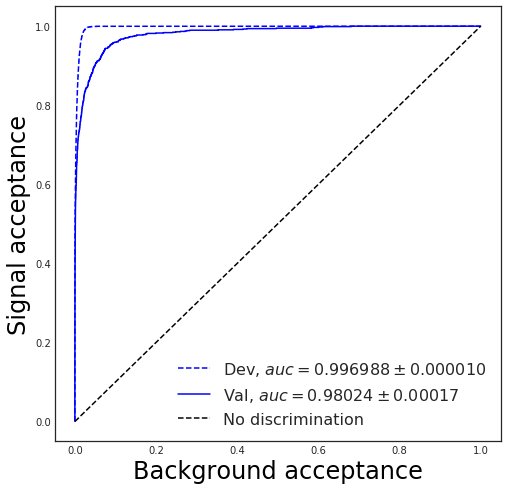

In [34]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(devData['gen_target'].values, devData['pred_class'].values)[:2],
         label=r'Dev, $auc={:.6f}\pm{:.6f}$'.format(meanScores['Dev'][0], meanScores['Dev'][1]),
         linestyle='dashed', color='b')
plt.plot(*roc_curve(valData['gen_target'].values, valData['pred_class'].values)[:2],
         label=r'Val, $auc={:.5f}\pm{:.5f}$'.format(meanScores['Val'][0], meanScores['Val'][1]),
         color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

### MVA distribution
We can also plot the distribution of the predicted class

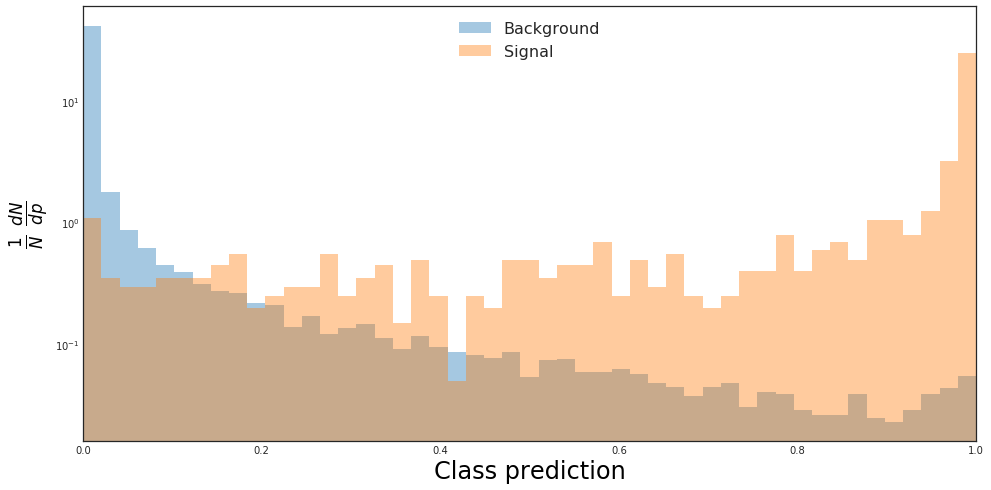

In [40]:
params = {'hist' : True, 'kde' : False, 'norm_hist' : True, 'bins' : np.linspace(0, 1, 50)}
plt.figure(figsize=(16, 8))
sns.distplot(valData[bkgVal]['pred_class'], label='Background', **params)
sns.distplot(valData[sigVal]['pred_class'], label='Signal', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
plt.xlim([0,1])
plt.yscale('log', nonposy='clip')
plt.show()

## Output classified data to ROOT TTree
In case you require the classified data to be in ROOT format we can convert it back.

In [36]:
if useROOT:
    array = np.array([tuple(x) for x in devData.values], dtype=[(x, np.float64) for x in devData.columns])
    root_numpy.array2root(array, loc + 'classifiedDevData.root', mode='recreate')
    array = np.array([tuple(x) for x in valData.values], dtype=[(x, np.float64) for x in valData.columns])
    root_numpy.array2root(array, loc + 'classifiedValData.root', mode='recreate')

## Save/load
We can save the classifier and load it later

In [37]:
name = "weights/NN_{}_{}".format(varSet, classModel)
print(name)


weights/NN_fsFeatures_model0


### Save

In [38]:
os.system("mkdir weights")
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble): #This is the other way of saving Keras models
    json_string = model.to_json()
    open("{0}_{1}.json".format(name, i), 'wb').write(str.encode(json_string)) #Save layout as json
    model.save_weights(name + '_' + str(i) + '.h5') #Save weights as h5
with open(name + '_compile.pkl', 'w') as fout: #Save compile arguments; loaded model might need recompiling
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'wb') as fout: #Save weights for ensembling
    cPickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout: #Save the pre-processing pipeline
    cPickle.dump(inputPipe, fout)


### Load

In [39]:
ensemble = []
weights = None
inputPipe = None
compileArgs = None
with open(name + '_compile.pkl', 'r') as fin:
    compileArgs = json.load(fin)
#for i in range(ensembleSize):
#    model = model_from_json(open(name + '_' + str(i) + '.json').read(), )
#    model.load_weights(name + "_" + str(i) + '.h5')
#    model.compile(**compileArgs)
#    ensemble.append(model)
with open(name + '_weights.pkl', 'rb') as fin:
    weights = cPickle.load(fin)
with open(name + '_inputPipe.pkl', 'rb') as fin:
    inputPipe = cPickle.load(fin)